In [1]:
import zfit
import math
from zfit import z
import numpy as np
import tensorflow as tf
from scipy.optimize import minimize

zfit.settings.options['numerical_grad'] = True
class HistPDF(zfit.pdf.BasePDF):

    def __init__(self, hist_args, hist_bins, obs, name='HistPDF'):
        self.rv_hist = scipy.stats.rv_histogram([hist_args, hist_bins])
        super().__init__(obs=obs, name=name)

    def _unnormalized_pdf(self, x):
        x = z.unstack_x(x)
        probs =  z.py_function(func=self.rv_hist.pdf, inp=[x], Tout=tf.float64)
        probs.set_shape(x.shape)
        return probs

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: zfit is being actively developed and keeps up with the newest versions of other packages.
This includes Python itself. Therefore, Python 3.6 will be dropped in the near future (beginning of May 2021)
and 3.9 will be added to the supported versions.

Feel free to contact us in case of problems to upgrade to a more recent version of Python.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/anaconda3/lib/python3.6/site-packages/zfit/util/execution.py:73: UserWarning: Not running on Linux. Determining available cpus for thread can failand be 

In [2]:
# mu2 = zfit.Parameter("mu2", 5., step_size=0)
# sigma2 = zfit.Parameter("sigma2", 1., step_size=0)
# lambd2 = zfit.Parameter("lambda2", -0.2, step_size=0)
# frac2 = zfit.Parameter("fraction2", 0.5, 0, 1)
# frac1 = zfit.Parameter("fraction1", 0.5, step_size=0)
# create space
obs1 = zfit.Space("x", limits=(0, 10))
obs2 = zfit.Space("x", limits=(0, 10))

# parameters
mu1 = zfit.Parameter("mu1", 5., 1, 10, step_size=0)
sigma1 = zfit.Parameter("sigma1", 1., 0.1, 10, step_size=0)
lambd1 = zfit.Parameter("lambda1", -0.2, -1, -0.01, step_size=0)
frac1 = zfit.Parameter("fraction1", 0.3, 0, 1, step_size = 0)

mu2 = zfit.Parameter("mu2", 5., step_size=0)
sigma2 = zfit.Parameter("sigma2", 1., step_size=0)
lambd2 = zfit.Parameter("lambda2", -0.2, step_size=0)
frac2 = zfit.Parameter("fraction2", 0.3, 0, 1, step_size = 0)


gauss1 = zfit.pdf.Gauss(mu=mu1, sigma=sigma1, obs=obs1)
exponential1 = zfit.pdf.Exponential(lambd1, obs=obs1)
model1 = zfit.pdf.SumPDF([gauss1, exponential1], fracs=[frac1])


gauss2 = zfit.pdf.Gauss(mu=mu2, sigma=sigma2, obs=obs2)
exponential2 = zfit.pdf.Exponential(lambd2, obs=obs2)
model2 = zfit.pdf.SumPDF([gauss2, exponential2], fracs=frac2)

In [29]:
n_sample = 500000

exp_data = exponential2.sample(n=n_sample * (1 - frac1)).numpy()

gauss_data = gauss2.sample(n=n_sample * frac1).numpy()




data = model1.create_sampler(n_sample, limits=obs1)
data.resample()

In [30]:
data_np = data[:, 0].numpy()
exp_data_np = exp_data[:, 0]
gauss_data_np = gauss_data[:, 0]


data_hist = np.histogram(data_np, bins=100)
exp_data_hist = np.histogram(exp_data_np, bins=100)
gauss_data_hist = np.histogram(gauss_data_np, bins=100)
sim_hists = []
sim_hists.append(exp_data_hist)
sim_hists.append(gauss_data_hist)

In [31]:
#tnp version!!!
import scipy
import tensorflow.experimental.numpy as tnp 
import tensorflow_probability as tfp  # 

class FractionFitterV4:

    def __init__(self, data_hist, sim_hists, P):
        self.data_hist = data_hist
        self.P = np.array(P)  # vectorization 3
        self.sim_hists = [hist for hist in sim_hists]
        self.d = np.array(self.data_hist[0]) # where d[i] amount of events in bin from data
        self.N_D = np.sum(self.d)#all observable data amount

        # vectorization 3
        self.N = np.array([np.sum(h[0]) for h in sim_hists])# amount of simulation data from sources e.g. N[0] from source 0 .. N[j] from source j
        self.sources_num = len(P)
        self.bins_num = len(data_hist[0])
        print(self.N_D)
        print(self.P)
        self.p = self.N_D * self.P / self.N
        #a[j][i] amount of observations in i bin from j source
        self.a = tf.constant([self.sim_hists[j][0] for j in range(self.sources_num)], dtype="float64")
        #self.a = tnp.array([self.sim_hists[j][0] for j in range(self.sources_num)], dtype="int64")
        self.nonzero_indices = np.where(self.d != 0)[0]
        self.nonzero_indices_tf = np.array([[i] for i in self.nonzero_indices])
        zfit.run.set_autograd_mode(False)
        zfit.run.set_graph_mode(False)
        
    
    def norma(self, v):
        return math.sqrt(sum(v ** 2))
    #function to minimize for finding optimal t according to (15) from the paper        
    
    @tf.function(autograph=False)
    def f_vectorized(self, t, p): 
        term1 = tnp.sum(p[:, None]* tf.gather(self.a, self.nonzero_indices, axis=1) / (1 + p[:, None] * t[None, :]), axis=0)
        term2 = self.d[self.nonzero_indices]/(1 - t)
        return term1 - term2
    
    @tf.function(autograph=False)
    def jac_f(self, t, p):
            return tnp.diag(tnp.sum((p[:, None] * tf.gather(self.a, self.nonzero_indices, axis=1) * p[:, None])/(1 + p[:, None] * t[None, :])**2, axis=0) + self.d[self.nonzero_indices]/(1 - t)**2)
    
    @tf.function(autograph=False)
    def sqF(self, p):
        t = tnp.ones_like(self.d, dtype="float64")
#         t = np.ones_like(self.d, dtype="float64")
        p = tnp.array(list(p))
        x0 = t[self.nonzero_indices] * 0
        high_bound = tnp.ones_like(self.nonzero_indices, dtype="float64")
        low_bound = high_bound * (-1/tnp.max(p))
#         tf.print(high_bound)
        def func_to_minimize(t):
            return self.f_vectorized(t, p)
#         t_solved = scipy.optimize.root(func_to_minimize,
#                                x0=x0, 
#                                method='hybr',  # 'krylov',
#                                tol=None,
#                                callback=None,
#                                options={}).x # bounds(-1/max(p), 1)
#         t[self.nonzero_indices] = t_solved
        t_solved = tfp.math.find_root_chandrupatla(func_to_minimize, low_bound, high_bound).estimated_root
#         tf.print(t_solved)
        t = tf.tensor_scatter_nd_update(t, self.nonzero_indices_tf, t_solved)
#         A = tf.constant(self.a/(1 + p[:, None]*t[None, :]), dtype="float64") 
        A = tnp.maximum(self.a/(1 + p[:, None]*t[None, :]), 0.05)
        
        return tnp.sum(tnp.sum(self.d[None, :] *  A / tnp.sum(p[None, :] * A.transpose(), axis=1) - A, axis=1)**2, axis=0)

    sqF.errordef = 0.5
    
    def fit(self, eps):
        minimizer = zfit.minimize.Minuit(tol=eps) 
        def func(x):
            # print(x)
            # if not tf.is_tensor(x):
            x = list(x)
            return self.sqF(x)
        func.errordef = 0.5

        return np.array(minimizer.minimize(func, self.p).params)   

In [32]:
fitter = FractionFitterV4(data_hist=data_hist, sim_hists=sim_hists, P=[0.4, 0.6])

500000
[0.4 0.6]


In [33]:
%%timeit for _ in range(2): True
p = fitter.fit(1e-3)

1.8 s ± 83.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print(fitter.a)# 1.64 , 1.72 s, 1.83, 2.36 s

In [ ]:
P = []
for j in range(len(p)):
    P.append(p[j] * fitter.N[j]/fitter.N_D)
P

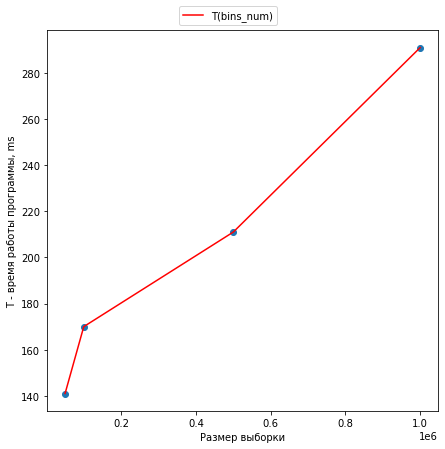

In [37]:
# 275  ms ± 13.2 ms
# 291  ms ± 4.6 ms
# 320  ms ± 1.53 ms
# 497  ms ± 9.2 ms
# 5790 ms ± 869 ms

import matplotlib.pyplot as plt
%matplotlib inline
bins = [50000, 100000, 500000, 1000000]
times = [141, 170, 211, 291]
plt.figure(figsize=(7, 7))
plt.xlabel('Размер выборки')
plt.ylabel('T - время работы программы, ms')
plt.scatter(bins, times)
plt.plot(bins, times, 'r', label='T(bins_num)')
plt.legend(bbox_to_anchor=(0.6, 1), loc=4)
plt.show()